In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cn
import scipy.optimize as so
import PyTMCI as vs
from PyTMCI.impedances import transverse_resonator
import tqdm                          # Adds a progress bar

from joblib import Parallel, delayed

Using Numba optimised Laguerre methods.
Using Numba optimised Airbag methods.
Using Numba optimised NHT methods.


## Accelerator Definition

In [2]:
ISIS = vs.accelerator(163.3,
                      cn.m_p,
                      cn.e,
                      0.45,
                      3.83,
                      0.015,
                      5.034**(-2),
                      -0.5,
                      1)

N = 1.3e13

## Impedance Model

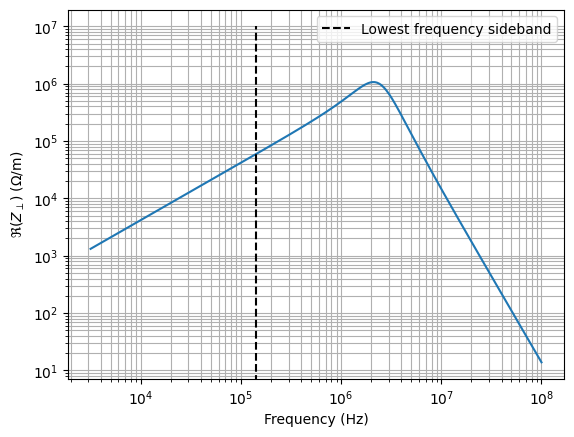

In [3]:
def zperp(f):
    return (
            transverse_resonator(f, 2.4e6, 1e6, 1, ISIS.beta)
           )

f = np.logspace(3.5, 8, 300)
plt.plot(f, np.real(zperp(f)))
plt.vlines((4 - ISIS.Q_b) * ISIS.f0, 0, 1e7,
           color='black', linestyle='dashed', label='Lowest frequency sideband')
# plt.vlines((5 - ISIS.Q_b) * ISIS.f0, 0, 1e6)
plt.xscale('log')
plt.yscale('log')
plt.grid(which='both')
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\Re( Z_{\perp} )$ ($\Omega$/m)")
plt.legend(loc='upper right')
plt.show()

## Longitudinal Distribution

In [4]:
def gaus(r, sigma=1):
    '''
    Gaussian radial distribution in longitudinal phase space, with
    the appropriate normalisation for Laguerre Polynomial sum.
    '''
    return np.atleast_1d(1/sigma**2 * np.exp(-r**2/2/sigma**2))

def g0hat(r):
    return gaus(r, sigma=6.5)

# Arbitrary Longitudinal Model (Laguerre Polynomial Sum)

In [5]:
# Define arbitrary longitudinal object

meth_lag = vs.arbitraryLongitudinal(ISIS,
                                    max_l=16,
                                    max_n=8)

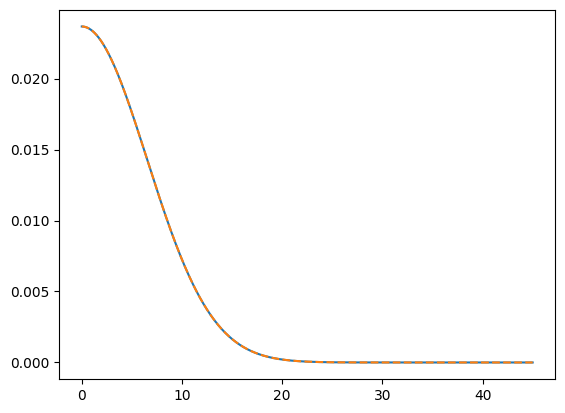

[ 2.36686391e-02 -8.95117314e-15 -7.76939277e-15]


In [6]:
# Perform fitting on unperturbed longitudinal distribution.
# Plot results to check.
a, Gk = meth_lag.calculateGk(0.5/(6.5)**2, 3, g0hat, method='laguerre-gauss', numerical_normalise=False)
r = np.linspace(0, 45, 1000)
plt.figure()
plt.plot(r, g0hat(r), 'C0')
plt.plot(r, meth_lag.g0Hat(r), 'C1--')
plt.show()
print(Gk)

In [7]:
start = time.time()

# Generate the base matrix
b = meth_lag.generateBaseMatrix('perturbed-full', zperp, 3500, 0)

# Generate the interaction matrix using the base matrix
c = meth_lag.generateInteractionMatrix(N)

# Investigate results
lag_eigenvalues, lag_eigenvectors = np.linalg.eig(c)

stop = time.time()
print(f"Calculation took {stop-start:.2f} s")

Calculation took 6.07 s


In [8]:
lag_eigenvalue_index = vs.find_most_unstable(lag_eigenvalues)
print(lag_eigenvalues[lag_eigenvalue_index])
print(f"Fastest Growth time = {1/(np.imag(lag_eigenvalues[lag_eigenvalue_index])*ISIS.w_s)*1e6:.1f} us")

(-1.2524031918168752+0.16942225103089173j)
Fastest Growth time = 75.8 us


## Perturbed Distribution

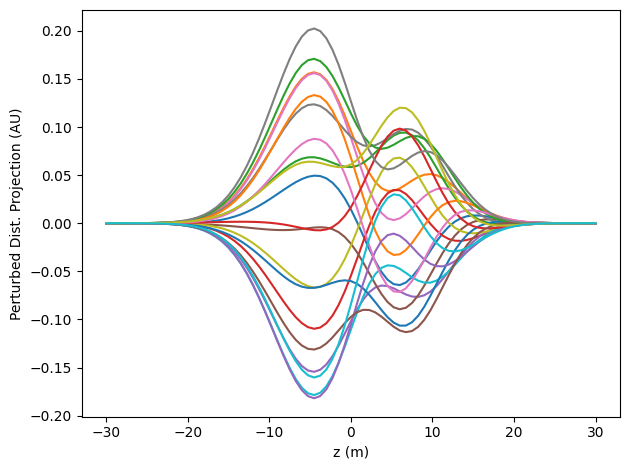

In [9]:
# Plot the projection of the distribution onto the
# z-axis by summing up all the rows for every column. 

num_slices = 81
max_r = 30

mat = meth_lag.g1(lag_eigenvectors[:, lag_eigenvalue_index], max_r, num_slices)
dist_Omega = meth_lag.Omega(lag_eigenvalues[lag_eigenvalue_index])

zz = np.linspace(-max_r, max_r, num_slices)

# Project to get distribution
line = np.zeros(np.shape(mat)[0], dtype=np.complex128)
for n, i in enumerate(mat.T):
    line[n] = np.sum(i)

    
offset_turns = 100

plt.figure()
# loop over turns and plot the distribution vs. z on each turn
for i in range(20):
    dist_s = (offset_turns + i) * ISIS.circumference
    plt.plot(zz, np.real(line*np.exp(-1j * dist_Omega * dist_s / ISIS.beta / cn.c)))


plt.xlabel("z (m)")
plt.ylabel("Perturbed Dist. Projection (AU)")
plt.tight_layout()
plt.show()

## NHT

In [10]:
# Define new NHT object

meth_nht = vs.NHT(ISIS, 16, 15)

In [11]:
# Choose ring radii
meth_nht.calculateRingRadii(g0hat, 6.5 * 5)

array([ 1.69253689,  2.98378343,  3.92506962,  4.73834544,  5.4899028 ,
        6.21257475,  6.9278172 ,  7.65316515,  8.40612622,  9.20755278,
       10.08641175, 11.08926378, 12.30462007, 13.94877917, 16.95291063])

In [12]:
start = time.time()

# Generate the base matrix
b = meth_nht.generateBaseMatrix('perturbed-full', zperp, 3500, 0)

# Generate the interaction matrix using the base matrix
c = meth_nht.generateInteractionMatrix(N)

# Investigate results
nht_eigenvalues = np.linalg.eigvals(c)

stop = time.time()
print(f"Calculation took {stop-start:.2f} s")

Calculation took 26.13 s


In [13]:
nht_eigenvalue_index = vs.find_most_unstable(nht_eigenvalues)

print(nht_eigenvalues[nht_eigenvalue_index])
print(f"NHT Growth time = {1/(np.imag(nht_eigenvalues[nht_eigenvalue_index])*ISIS.w_s)*1e6:.1f} us")

(-1.2583030385803085+0.16966178871896415j)
NHT Growth time = 75.7 us


# Airbag Benchmarks

In [14]:
meth_airbag = vs.airbag(ISIS, 16, 6.5*np.sqrt(2))

In [15]:
# No longitudinal distribution required. Ring radii
# specified in object definition.

In [16]:
start = time.time()

# Generate the base matrix
b = meth_airbag.generateBaseMatrix('perturbed-full', zperp, 3500, 0)

# Generate the interaction matrix using the base matrix
c = meth_airbag.generateInteractionMatrix(N)

# Investigate results
airbag_eigenvalues = np.linalg.eigvals(c)

stop = time.time()
print(f"Calculation took {stop-start:.2f} s")

Calculation took 2.09 s


In [17]:
airbag_eigenvalue_index = vs.find_most_unstable(airbag_eigenvalues)

print(airbag_eigenvalues[airbag_eigenvalue_index])
print(f"Airbag Growth time = {1/(np.imag(airbag_eigenvalues[airbag_eigenvalue_index])*ISIS.w_s)*1e6:.1f} us")

(-1.2925399426452489+0.2218681413100742j)
Airbag Growth time = 57.9 us


# Sweeps of N

## Laguerre Polynomials

In [18]:
N = np.linspace(1e12, 4e13, 40)

def wrapper(particles_per_bunch):
    return np.linalg.eigvals(meth_lag.generateInteractionMatrix(particles_per_bunch))

sweep_lag_eigenvalues = np.array(Parallel(n_jobs=8)(delayed(wrapper)(i) for i in tqdm.tqdm(N)))

100%|██████████| 40/40 [00:01<00:00, 34.08it/s]


In [19]:
def wrapper(particles_per_bunch):
    return np.linalg.eigvals(
        meth_nht.generateInteractionMatrix(particles_per_bunch)
    )

sweep_nht_eigenvalues = np.array(Parallel(n_jobs=8)(delayed(wrapper)(i) for i in tqdm.tqdm(N)))

100%|██████████| 40/40 [00:01<00:00, 33.24it/s]


In [20]:
def wrapper(particles_per_bunch):
    return np.linalg.eigvals(
        meth_airbag.generateInteractionMatrix(particles_per_bunch)
    )

sweep_airbag_eigenvalues = np.array(Parallel(n_jobs=8)(delayed(wrapper)(i) for i in tqdm.tqdm(N)))

100%|██████████| 40/40 [00:00<00:00, 2753.48it/s]


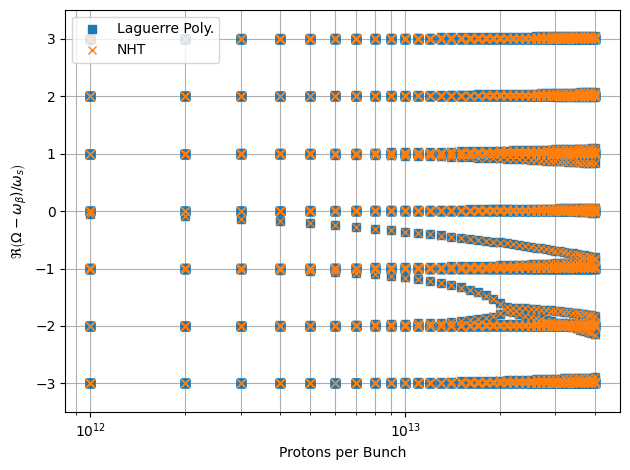

In [21]:
fig, ax = plt.subplots(1, 1)

for i in range(np.shape(sweep_lag_eigenvalues)[1]):
    ln = ax.plot(N, np.real(sweep_lag_eigenvalues[:, i]), 'C0s')
    if i == 0:
        ln[0].set_label("Laguerre Poly.")

for i in range(np.shape(sweep_nht_eigenvalues)[1]):
    ln = ax.plot(N, np.real(sweep_nht_eigenvalues[:, i]), 'C1x')
    if i == 0:
        ln[0].set_label("NHT")
    
ax.set_xscale('log')
ax.set_ylim(-3.5, 3.5)
ax.grid(which='both')
ax.set_ylabel(r"$ \Re \left( \Omega - \omega_\beta)/\omega_s \right)$")
ax.set_xlabel("Protons per Bunch")
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

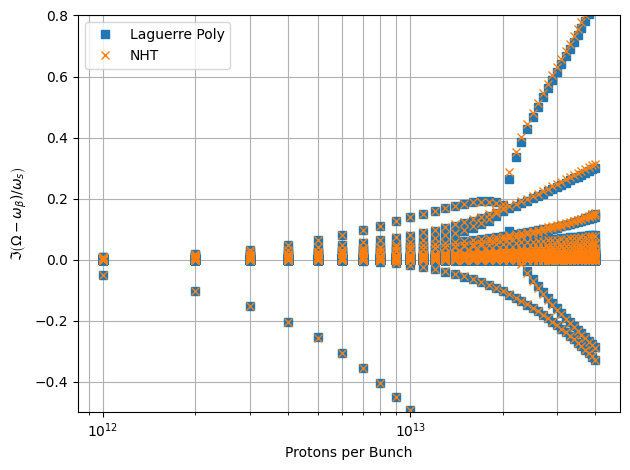

In [22]:
fig, ax = plt.subplots(1, 1)
for i in range(np.shape(sweep_lag_eigenvalues)[1]):
    lni = ax.plot(N, np.imag(sweep_lag_eigenvalues[:, i]), 'C0s')
    if i == 0:
        lni[0].set_label("Laguerre Poly")

for i in range(np.shape(sweep_nht_eigenvalues)[1]):
    lni = ax.plot(N, np.imag(sweep_nht_eigenvalues[:, i]), 'C1x')
    if i == 0:
        lni[0].set_label("NHT")
        
ax.set_xscale('log')
ax.set_ylim(-0.5, 0.8)
ax.grid(which='both')
ax.set_ylabel(r"$ \Im \left( \Omega - \omega_\beta)/\omega_s \right)$")
ax.set_xlabel("Protons per Bunch")
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

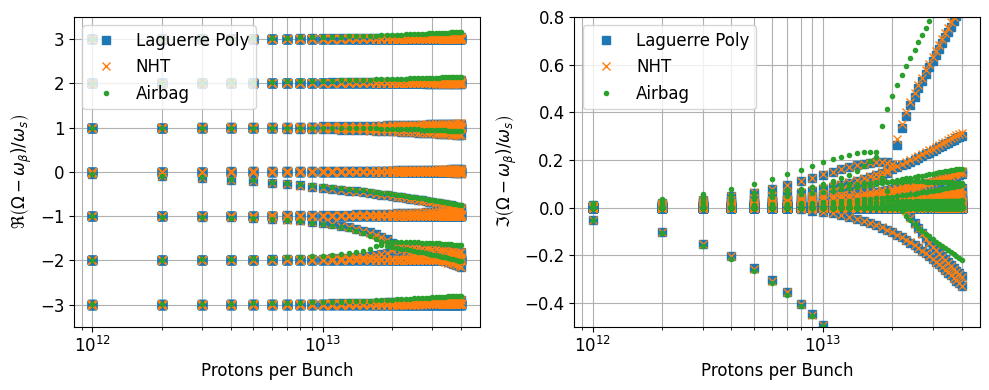

In [23]:
# Plot the eigenvalues
# A new cell is used so that the limits of the plot (etc) can be changed
# without having to recompute all the eigenvalues. 
fig, ax = plt.subplots(1, 2, figsize=(10, 4))


for i in range(np.shape(sweep_lag_eigenvalues)[1]):
    ln = ax[0].plot(N, np.real(sweep_lag_eigenvalues[:, i]), 'C0s')
    if i == 0:
        ln[0].set_label("Laguerre Poly")

for i in range(np.shape(sweep_nht_eigenvalues)[1]):
    ln = ax[0].plot(N, np.real(sweep_nht_eigenvalues[:, i]), 'C1x')
    if i == 0:
        ln[0].set_label("NHT")

for i in range(np.shape(sweep_airbag_eigenvalues)[1]):
    ln = ax[0].plot(N, np.real(sweep_airbag_eigenvalues[:, i]), 'C2.')
    if i == 0:
        ln[0].set_label("Airbag")


for i in range(np.shape(sweep_lag_eigenvalues)[1]):
    lni = ax[1].plot(N, np.imag(sweep_lag_eigenvalues[:, i]), 'C0s')
    if i == 0:
        lni[0].set_label("Laguerre Poly")

for i in range(np.shape(sweep_nht_eigenvalues)[1]):
    lni = ax[1].plot(N, np.imag(sweep_nht_eigenvalues[:, i]), 'C1x')
    if i == 0:
        lni[0].set_label("NHT")


for i in range(np.shape(sweep_airbag_eigenvalues)[1]):
    ln = ax[1].plot(N, np.imag(sweep_airbag_eigenvalues[:, i]), 'C2.')
    if i == 0:
        ln[0].set_label("Airbag")

    
ax[0].set_xscale('log')
ax[0].set_ylim(-3.5, 3.5)
ax[0].grid(which='both')
ax[0].set_ylabel(r"$ \Re \left( \Omega - \omega_\beta)/\omega_s \right)$", fontsize=12)
ax[0].set_xlabel("Protons per Bunch", fontsize=12)
ax[0].legend(loc='upper left', fontsize=12)
ax[0].tick_params(labelsize=12)

ax[1].set_xscale('log')
ax[1].set_ylim(-0.5, 0.8)
ax[1].grid(which='both')
ax[1].set_ylabel(r"$ \Im \left( \Omega - \omega_\beta)/\omega_s \right)$", fontsize=12)
ax[1].set_xlabel("Protons per Bunch", fontsize=12)
ax[1].legend(loc='upper left', fontsize=12)
ax[1].tick_params(labelsize=12)

plt.tight_layout()
plt.show()